In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
'''
Please install this specific version of resampy for librosa to work without errors.
'''

'\nPlease install this specific version of resampy for librosa to work without errors.\n'

In [3]:
pip install resampy==0.3.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
import soundfile
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import librosa
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
import warnings; warnings.filterwarnings('ignore')

In [5]:
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

### Data for binary classification


In [6]:
def load_extract_features(data_path):

    '''
    load_extract_features() is a function that is used to load all the audio files one at a time, compute their features and return the features as well as the target values.

    There are around 8-10 audio files which are corrupted. We hardcode zero values for such files in order to maintain consistency.

    ['calm', 'happy'] emotion data is categorized into 'positive' and  ['angry', 'fearful'] into 'negative'

    Returns:
    1. Features
    2. Binary Target Values
    '''
    final_features,target_emotions, binary_label = [],[], []
    count = 0
    
    for i in glob.glob(data_path + "/Actor_*/*.wav"): #Loop to read every file.
        #print the folder name
        
        
        name = os.path.basename(i)
        #We split the name of the file to understand the emotion associated with the file.
        split = name.split("-")
        #We know that the third identifier is associated with the emotion of the audio file. Hence, we use [2] as it represents the third identifier.
        emotion = emotions[split[2]]

        #Below is the code to categorize the emotions into two classes to make this a binary problem.
        if emotion in ['calm', 'happy']:
            binary_label.append(0)
        elif emotion in ['angry', 'fearful']:
            binary_label.append(1)
        else:
            continue
        
        with soundfile.SoundFile(i) as audio:
            waveform = audio.read(dtype="float32")
            sr = audio.samplerate
            #Below is the code to extract the Mel spectrogram features
            #128 is the standard for machine learning applications using Mel spectrograms
            m_feature = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=128, fmax=sr / 2.0).T
            melspectrogram = np.mean(m_feature,axis=0)
            if melspectrogram.shape != (128,):
                melspectrogram = np.zeros(128)
            
            #Below is the code to extract the chromagram features
            stft_wave = librosa.stft(waveform)
            stft = np.abs(stft_wave)
            c_feature = librosa.feature.chroma_stft(S=stft, sr=sr).T
            chromagram = np.mean(c_feature,axis=0)
            
            #12 is the number of pitch classes
            if chromagram.shape != (12,):
                chromagram = np.zeros(12)
                
            features=np.array([])
            features=np.hstack((chromagram, melspectrogram))
        
            final_features.append(features)
            target_emotions.append(emotion)
            
            count += 1
            if count % 100 == 0:
                print("Processed Audio File Number: ", count)
    #We return the features and the binary target values.
    return np.array(final_features), np.array(binary_label)

In [7]:
data_path = './Audio_speech'
X, binary_label = load_extract_features(data_path)

Processed Audio File Number:  100
Processed Audio File Number:  200
Processed Audio File Number:  300
Processed Audio File Number:  400
Processed Audio File Number:  500
Processed Audio File Number:  600
Processed Audio File Number:  700


##### Split the data into training and testing sets

In [8]:
#splitting the data into train and test, 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, binary_label, test_size=0.3, random_state=2)


## Part a

#### KNN Classifier

In [9]:
print("Shape of the training data: ", X_train.shape)
print("Shape of the test data: ", X_test.shape)

Shape of the training data:  (537, 140)
Shape of the test data:  (231, 140)


##### Euclidian Distance

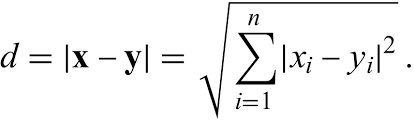

In [10]:
#Find the euclidean distance between 2 points (with all features)
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

##### KNN Implementation

In [11]:
### KNN Algorithm
# Find the K nearest neighbors of a given test point and return the majority label

def knn(X_train, y_train, x_test, k):
    # create an empty list for distances and targets
    distances = []
    targets = []

    for i in range(len(X_train)):
        # first we compute the distance between the test point and each of the points in the training data
        distances.append(euclidean_distance(x_test, X_train[i]))

    # then we sort the distances and return the indices of k neighbors with smallest distances
    distances = np.argsort(distances)[:k]
    
    # extract the labels of the k nearest neighbor training samples
    for i in distances:
        targets.append(y_train[i])
    
    return np.bincount(targets).argmax()


In [12]:
print(X_train)
print(y_train.shape)

[[5.82607687e-01 5.87497294e-01 5.36086857e-01 ... 2.16505214e-05
  1.52670771e-06 1.24583055e-08]
 [6.77873254e-01 6.94192231e-01 7.28075385e-01 ... 3.28271653e-07
  3.80796763e-08 6.39809006e-09]
 [5.93248367e-01 5.35110950e-01 5.05916178e-01 ... 1.35429952e-08
  6.15183637e-09 5.58863222e-09]
 ...
 [7.60035753e-01 7.07430303e-01 6.72383249e-01 ... 6.02721184e-06
  4.57740924e-07 9.56672697e-09]
 [6.68856084e-01 6.79820716e-01 6.76023781e-01 ... 4.96273515e-06
  4.50451466e-07 1.01526254e-08]
 [6.23803198e-01 5.70699096e-01 4.86201495e-01 ... 4.08224956e-08
  9.31905841e-09 7.84120147e-09]]
(537,)


##### Cross Validation

In [13]:

def cross_validate(X, y, k_values, folds):
    # Number of data points
    num_data_points = X.shape[0]
    # Create an array of indices and shuffle it
    indices = np.arange(num_data_points)
    np.random.shuffle(indices)
    # Split the indices into k equal parts
    fold_indices = np.array_split(indices, folds)
    # Initialize a 2D numpy array to store the accuracies
    accuracies = np.zeros((len(k_values), folds))

    # For each fold
    for i in range(folds):
        # Make the validation set by taking the ith part as the test set
        test_indices = fold_indices[i]
        X_test = X[test_indices]
        y_test = y[test_indices]
        # Make the training set by taking all other parts as the training set
        train_indices = np.concatenate(fold_indices[:i] + fold_indices[i+1:])
        X_train = X[train_indices]
        y_train = y[train_indices]

        # For each k value
        for j, k in enumerate(k_values):
            # Fit the model on the training set
            y_pred = [knn(X_train, y_train, x, k) for x in X_test]
            # Compute the accuracy on the test set and store it in the accuracies array
            accuracies[j, i] = np.mean(y_test == y_pred)

    # Return the accuracies array
    return accuracies


k = 1 : 0.7167714884696017
k = 2 : 0.6535639412997903
k = 3 : 0.7279874213836478
k = 4 : 0.7074423480083857
k = 5 : 0.729979035639413
k = 6 : 0.7187281621243886
k = 7 : 0.7430118798043326
k = 8 : 0.7205450733752621
k = 9 : 0.7317610062893082
k = 10 : 0.7205800139762404
k = 11 : 0.7056953179594688
k = 12 : 0.7150244584206848
k = 13 : 0.7093990216631727
k = 14 : 0.7057302585604472
k = 15 : 0.7149895178197065
k = 16 : 0.7038784067085954
k = 17 : 0.7169112508735149
k = 18 : 0.7020614954577218
k = 19 : 0.7169461914744935
k = 20 : 0.7113906359189378


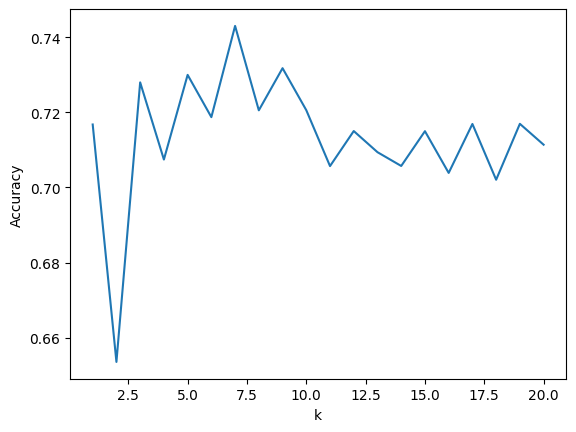

In [14]:
# define k values to be 1-20
k_values = list(range(1, 21))


#perform 10 fold cross validation
accuracies = cross_validate(X_train, y_train, k_values, 10)

# print the average accuracy for each k value
for i, k in enumerate(k_values):
    print("k =", k, ":", np.mean(accuracies[i]))

# plot the average accuracies for each k value
import matplotlib.pyplot as plt
plt.plot(k_values, np.mean(accuracies, axis=1))
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()



In [15]:
#pick the best k value
best_k = k_values[np.argmax(np.mean(accuracies, axis=1))]
print("Best k value:", best_k)


Best k value: 7


In [16]:
#Predict on the test set and report the accuracy as well as runtime
import time
start_time = time.time()
y_pred = [knn(X_train, y_train, x, best_k) for x in X_test]
accuracy  = np.mean(y_test == y_pred)
time_taken = time.time() - start_time
#Percentage of correct predictions
print("Accuracy = ", accuracy*100, "%")
print("Runtime = ", time_taken, "seconds")



Accuracy =  73.59307359307358 %
Runtime =  1.9866302013397217 seconds


## Part B -PCA

In [17]:
#implementing PCA to reduce the dimensionality of the data

def pca(X, num_components):
    # Standardize the data
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # Compute the covariance matrix
    cov = np.cov(X.T)
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    # Sort the eigenvalues and eigenvectors
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:, sorted_index]
    # select the first num_components eigenvectors
    eigenvectors = eigenvectors[:, :num_components]
    # Project the data onto the eigenvectors
    X_pca = np.dot(X, eigenvectors)
    return X_pca


#### Finding the best #components that achieves 90-95% variance (as per Piazza recommendation)

Number of components needed to retain 95% of variance: 32


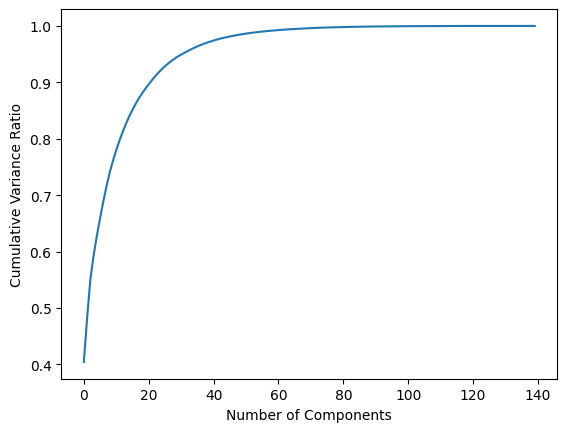

In [18]:
def plot_cumulative_variance(X):
    # Standardize the data
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # Compute the covariance matrix
    cov = np.cov(X.T)
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    # Sort the eigenvalues and eigenvectors
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:, sorted_index]
    # Compute the cumulative variance ratio
    cumulative_variance_ratio = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    # Find the number of components needed to retain 95% of variance
    num_components = find_num_components(cumulative_variance_ratio, 0.95)
    print("Number of components needed to retain 95% of variance:", num_components)
    # Plot the cumulative variance ratio
    plt.plot(cumulative_variance_ratio)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Ratio")
    plt.show()
    return num_components


def find_num_components(cumulative_variance_ratio, threshold):
    # Find the number of components needed to retain threshold fraction of variance
    num_components = np.argmax(cumulative_variance_ratio > threshold) + 1
    return num_components

num_components = plot_cumulative_variance(X_train)

In [19]:
# Reduce the dimensionality of the sets
X_train_pca = pca(X_train, num_components)
X_test_pca = pca(X_test, num_components)

k = 1 : 0.6926974143955276
k = 2 : 0.7018867924528303
k = 3 : 0.7206848357791753
k = 4 : 0.7092592592592593
k = 5 : 0.7244234800838574
k = 6 : 0.7205450733752621
k = 7 : 0.7112159329140462
k = 8 : 0.7056254367575121
k = 9 : 0.7280223619846261
k = 10 : 0.7056603773584905
k = 11 : 0.7168064290705799
k = 12 : 0.7111809923130679
k = 13 : 0.7186582809224318
k = 14 : 0.7149545772187282
k = 15 : 0.7130677847658979
k = 16 : 0.7074074074074075
k = 17 : 0.7055904961565339
k = 18 : 0.7037037037037037
k = 19 : 0.7093990216631727
k = 20 : 0.7074772886093641


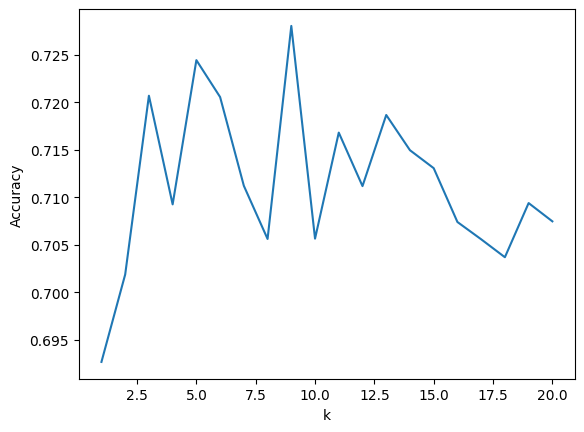

In [20]:
k_values = list(range(1, 21))
accuracies = cross_validate(X_train_pca, y_train, k_values, 10)
for i, k in enumerate(k_values):
    print("k =", k, ":", np.mean(accuracies[i]))

# plot the average accuracies for each k value
plt.plot(k_values, np.mean(accuracies, axis=1))
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()


In [21]:
#pick the best k value
best_k = k_values[np.argmax(np.mean(accuracies, axis=1))]
print("Best k value:", best_k)

Best k value: 9


In [22]:
#Predict on the test set and report the accuracy as well as runtime
import time
start_time = time.time()
y_pred = [knn(X_train_pca, y_train, x, best_k) for x in X_test_pca]
accuracy_pca  = np.mean(y_test == y_pred)
time_taken_pca = time.time() - start_time
#Percentage of correct predictions
print("Accuracy = ", accuracy_pca*100, "%")
print("Runtime = ", time_taken_pca, "seconds")


Accuracy =  66.23376623376623 %
Runtime =  1.77571702003479 seconds


#### comparing results from A and B

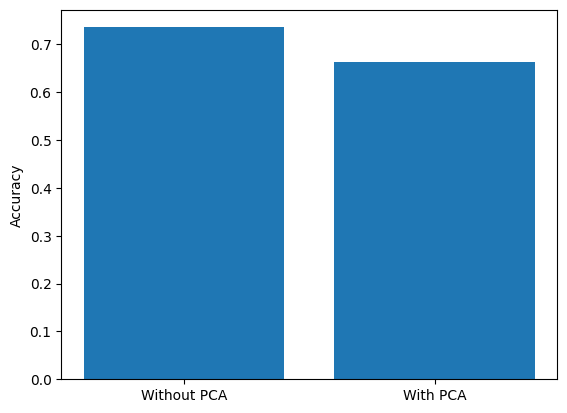

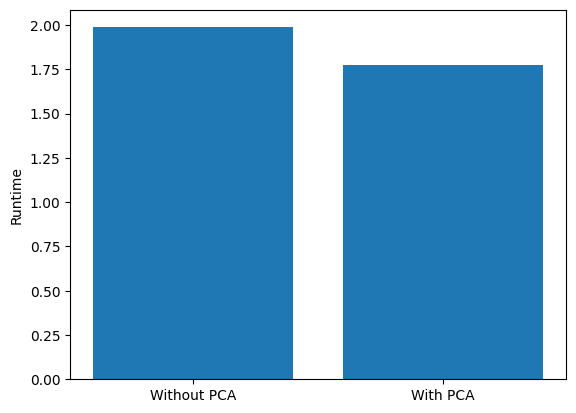

In [23]:
#plot the accuracy and runtime for both the models
plt.bar(["Without PCA", "With PCA"], [accuracy, accuracy_pca])
plt.ylabel("Accuracy")
plt.show()

plt.bar(["Without PCA", "With PCA"], [time_taken, time_taken_pca])
plt.ylabel("Runtime")
plt.show()
